<a href="https://colab.research.google.com/github/LeNovice/PSW/blob/main/Better_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
USE_ORIGINAL = 0
loss = 'categorical_crossentropy'

In [2]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models
import tensorflow.keras.utils as tfutils
import os
import copy

In [3]:
NUM_CLASSES = 10

DataSet = 'cifar10'
#'caltech101'
#'cifar10'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:(NUM_CLASSES + 1)]    #+1 because we are going to remove "backround_google" i.e. 4
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [4]:
#ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
if DataSet == 'caltech101':
    ds_train, train_info = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True, with_info = True)
else:
    ds_train, train_info = tfds.load(DataSet, split='train', as_supervised=True, with_info = True)
ds_test = tfds.load(DataSet, split='test', as_supervised=True)

In [5]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
if DataSet == 'caltech101':
  class_list = [i for i in class_list if i != train_info.features['label'].str2int('background_google')]
  class_list.sort()

"""for name in train_info.features['label'].names:
    print(name, train_info.features['label'].str2int(name))
"""

class_names = [train_info.features['label'].int2str(i) for i in class_list]
display(class_names)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
resized_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
resized_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

In [7]:
num_samples_per_class(resized_ds_train, print_all=True)

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000


[]

In [8]:
num_samples_per_class(resized_ds_test, print_all=True)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


[]

In [9]:
#Hyperparameters
if DataSet=='caltech101':
    IMG_SIZE = 60
elif DataSet=='cifar10':
    IMG_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE=128

input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)
#Relabelling to avoid issues. Note that human readability is reduced by this
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        #values=tf.constant([tfutils.to_categorical(0, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(1, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(2, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(3, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(4, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(5, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(6, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(7, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(8, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(9, num_classes=NUM_CLASSES, dtype=np.int64)],  dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64)
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

#This function will be used in the graph execution hence @tf.function prefix
@tf.function
def map_func(label):
    global class_list
    global loss
    mapped_label = table.lookup(label)
    if loss != 'sparse_categorical_crossentropy':
        mapped_label = tf.one_hot(indices=mapped_label, depth=NUM_CLASSES)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

#Preprocessing done as part of the graph
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

buffer_size = 30*NUM_CLASSES

#Preprocessing function which invokes above graphs
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        #ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resized_ds_train = prepare(resized_ds_train, augment=True)
resized_ds_test = prepare(resized_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("one_hot:0", shape=(10,), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

<tf.Tensor: shape=(), dtype=int64, numpy=7>

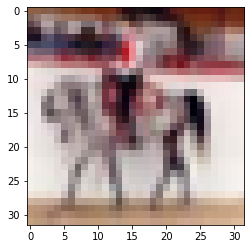

In [11]:
for example in resized_ds_train.take(1):
  plt.imshow(example[0])
  display((example[-1]))
  display(tf.argmax(example[-1]))
  #display(train_info.features['label'].int2str(example[-1]))

In [12]:
def num_samples_per_class_onehot(resized_ds_train, print_all=False):
    if loss != 'sparse_categorical_crossentropy':
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: tf.argmax(y)), int), return_counts=True)
    else:
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    class_hist.sort()
    return class_hist



In [13]:
#Post prepare function, all the labels will be converted to one hot encoders. In order to get class-wise distribution, we will need to convert each one hot encoder into its label (temporarily)
#We need a new function to handle it
class_hist = num_samples_per_class_onehot(resized_ds_train)
display(class_hist)

[(0, 10000),
 (1, 10000),
 (2, 10000),
 (3, 10000),
 (4, 10000),
 (5, 10000),
 (6, 10000),
 (7, 10000),
 (8, 10000),
 (9, 10000)]

In [14]:
#reg = tf.keras.regularizers.L2(0.01)
reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.1)
#reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.0)
#beta_regularizer = 0.1
#gamma_regularizer = 0.1

model = models.Sequential()
kernel_size = (3,3)
pool_size = (2,2)
if USE_ORIGINAL == 1:
	display("Original CadenceNet")
	#model.add(resize_and_rescale)
	#model.add(data_augmentation)
	kernel_size = (5,5)
	model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))

	kernel_size = (3,3)
	model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())                                                      #beta_regularizer = beta_regularizer, gamma_regularizer = gamma_regularizer
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Dropout(.2))

	kernel_size = (3,3)
	model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))

	model.add(layers.Flatten())
	model.add(layers.Dropout(.2))
	#model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))
	model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
	model.add(layers.Softmax())
else:
	display("VGG based CadenceNet")
	
	model.add(layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
	model.add(layers.BatchNormalization())
	model.add(layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.1))
	
	model.add(layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.2))
	
	model.add(layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.3))
	
	model.add(layers.Flatten())
	model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer = reg))
	model.add(layers.BatchNormalization())
	model.add(layers.Dropout(0.2))
	model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
	model.add(layers.Softmax())

'VGG based CadenceNet'

In [15]:
def get_class_weights(class_hist):
    """
    Returns the class weights as a tf.Tensor. Class weights are inverse of the class frequencies
    Class frequencies are the number of samples of each class which we calculate in earlier steps
    """
    inv_freq = tf.convert_to_tensor([1.0/count for label, count in class_hist], dtype=tf.float32)
    return tfutils.normalize(inv_freq)


def weightedloss(y_true, y_pred, gamma, class_weight):
    """
    We assume that all arguments coming into this function are tf.Tensors type
    class_weights are basically alpha in focal loss paper
    """
    #ones = tf.convert_to_tensor(np.ones(shape=len(y_true)))
    a = tf.math.multiply(tf.math.pow(tf.math.subtract(1.0, y_pred), gamma), tf.math.log(y_pred))  #((1-pt)^gamma)log(pt)
    b = tf.math.multiply(-1.0, class_weight)                                                          #-alpha
    b = tf.math.multiply(b,a)    
    b = tf.math.multiply(b, y_true)
    return b
class WeightedLoss(tf.keras.losses.Loss):
    def __init__(self, gamma, class_weight=np.ones(shape=NUM_CLASSES, dtype=np.float32)):
        super().__init__()
        self.gamma = tf.convert_to_tensor(gamma)
        self.class_weight = tf.convert_to_tensor(class_weight, dtype=tf.float32)
    def call(self, y_true, y_pred):
        return weightedloss(y_true, y_pred, self.gamma, self.class_weight)

In [16]:
Learning_Rate = 1e-5
#tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

In [17]:
###EITHER

#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss 
#model.compile( optimizer = opt, loss = SparseCategoricalFocalLoss(gamma=2), metrics=['accuracy'] )

In [18]:
###OR
model.compile( optimizer = opt, loss = loss, metrics=['accuracy'] )

In [19]:
###OR
#class_wts = get_class_weights(class_hist)
#display(class_wts)
#model.compile( optimizer = opt, loss = WeightedLoss(gamma=2.0, class_weight=class_wts), metrics=['accuracy'] )

In [20]:
#model.summary()

In [21]:
#h = model.fit( resized_ds_train, epochs=10)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test_unbatched = resized_ds_test
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)

h = model.fit( resized_ds_train, epochs=80, validation_data = resized_ds_test)

Epoch 1/80
782/782 [==============================] - 51s 55ms/step - loss: 112.4044 - accuracy: 0.1574 - val_loss: 104.1069 - val_accuracy: 0.2308
Epoch 2/80
782/782 [==============================] - 44s 57ms/step - loss: 97.3657 - accuracy: 0.2238 - val_loss: 90.1137 - val_accuracy: 0.2901
Epoch 3/80
782/782 [==============================] - 41s 53ms/step - loss: 84.1183 - accuracy: 0.2602 - val_loss: 77.7017 - val_accuracy: 0.3283
Epoch 4/80
782/782 [==============================] - 43s 55ms/step - loss: 72.3460 - accuracy: 0.2889 - val_loss: 66.6666 - val_accuracy: 0.3551
Epoch 5/80
782/782 [==============================] - 42s 54ms/step - loss: 61.8755 - accuracy: 0.3140 - val_loss: 56.8824 - val_accuracy: 0.3668
Epoch 6/80
782/782 [==============================] - 42s 54ms/step - loss: 52.6260 - accuracy: 0.3362 - val_loss: 48.2973 - val_accuracy: 0.3727
Epoch 7/80
782/782 [==============================] - 43s 55ms/step - loss: 44.5699 - accuracy: 0.3582 - val_loss: 40.8979

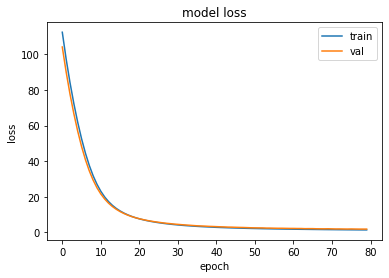

In [22]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

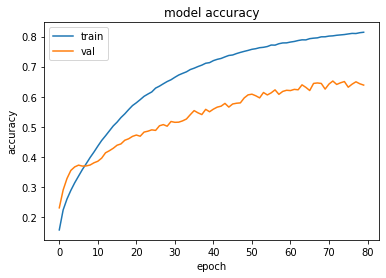

In [23]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
#Evaluation and confusion matrix creation:
from sklearn.metrics import classification_report, confusion_matrix

x_test = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(resized_ds_test_unbatched))))
y_test_orig = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(resized_ds_test_unbatched))))

In [25]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [26]:
if loss!='sparse_categorical_crossentropy':
    false_arr = np.full(shape=len(class_list), fill_value = False)
    #y_pred = np.empty(shape=y_test_orig.shape[-1])
    i=0
    for i, pred in enumerate(predictions):
        temp_arr = copy.deepcopy(false_arr)
        np.put(temp_arr, np.argmax(pred), True)
        if i==0:
            y_pred = copy.deepcopy(temp_arr)
        else:
            y_pred = np.vstack([y_pred, temp_arr])
    display(y_pred.shape)
else:
    y_pred = np.argmax(predictions, axis=1)


(10000, 10)

In [27]:
display(y_test_orig.shape)
display(y_pred.shape)

(10000, 10)

(10000, 10)

In [28]:
print('Confusion Matrix')
if loss != 'sparse_categorical_crossentropy':
    matrix = confusion_matrix(y_test_orig.argmax(axis=1), y_pred.argmax(axis=1))
else:
    matrix = confusion_matrix(y_test_orig, y_pred)
display(matrix)

# Print Classification Report
print('Classification Report')
print(classification_report(y_test_orig, y_pred, target_names=class_names))

Confusion Matrix


array([[832,  27,  37,  20,  21,   2,  11,  17,  21,  12],
       [ 16, 844,  12,   7,   2,   2,  31,   4,   7,  75],
       [ 71,  13, 585,  66,  93,   7, 110,  24,  18,  13],
       [ 28,  19,  71, 480,  74,  41, 172,  40,  27,  48],
       [ 16,   2,  58,  13, 765,   5, 114,  15,   6,   6],
       [ 10,  13,  49, 267,  67, 349, 126,  44,  29,  46],
       [  3,   6,  12,  15,  30,   3, 911,   5,   7,   8],
       [ 24,  10,  37,  78, 263,  10,  64, 465,  18,  31],
       [323,  46,  55,  28,  15,  10,  38,  12, 425,  48],
       [ 41,  95,   9,  36,   8,   1,  51,  15,  13, 731]])

Classification Report
              precision    recall  f1-score   support

    airplane       0.61      0.83      0.70      1000
  automobile       0.79      0.84      0.81      1000
        bird       0.63      0.58      0.61      1000
         cat       0.48      0.48      0.48      1000
        deer       0.57      0.77      0.65      1000
         dog       0.81      0.35      0.49      1000
        frog       0.56      0.91      0.69      1000
       horse       0.73      0.47      0.57      1000
        ship       0.74      0.42      0.54      1000
       truck       0.72      0.73      0.72      1000

   micro avg       0.64      0.64      0.64     10000
   macro avg       0.66      0.64      0.63     10000
weighted avg       0.66      0.64      0.63     10000
 samples avg       0.64      0.64      0.64     10000



NOT using below things

In [29]:
def ret_as_numpy():
    test = tfds.load(DataSet, split='test', as_supervised=True)
    test = prepare(test)
    test = tfds.as_numpy(test)
    return test

In [30]:
test_as_np = ret_as_numpy()

In [31]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    #display(output[0])
    #display(output)
    #display(digit)
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [36]:
test_accuracy_Float = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy_Float)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Float test_accuracy: 0.6387


Float checkpoint

In [37]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

In [38]:
q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

RuntimeError: ignored

In [ ]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))

resized_quantize_train = prepare(filtered_quantize_train)

In [ ]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
h = q_aware_model.fit(resized_quantize_train, epochs=5, validation_data = resized_ds_test)

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [ ]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!pip install -U tf2onnx==1.8.4
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNetOriginal_Float.onnx

In [ ]:
quant_file = "/content/CadenceNetOriginal_QAT.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

In [ ]:

print("Float model in Mb: ", os.path.getsize("/content/CadenceNetOriginal_Float.onnx") / float(2**20))
print("Quantized model in Mb: ", os.path.getsize(quant_file) / float(2**20))
print("Float Model Accuracy: ", test_accuracy_Float)
print("Quantized Model Accuracy: ", test_accuracy)

In [ ]:
!pip install onnxruntime
import onnxruntime as rt

sess = rt.InferenceSession("/content/CadenceNetOriginal_Float.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
x = np.random.random((1,IMG_SIZE,IMG_SIZE,NUM_CHANNELS))
x = x.astype(np.float32)
res = sess.run([output_name], {input_name: x})


In [ ]:
indices = tf.convert_to_tensor([0, 1, 2])
depth = 3
indic = tf.convert_to_tensor([3, 5, 8])
tf.math.multiply(indices, indic)

